<a href="https://colab.research.google.com/github/Pilo1961/Deep_Learning/blob/master/proyecto_final/embedding_encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook settings

In [0]:
# mount drive 
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import pandas as pd
import numpy as np

# Load original embedding

In [0]:
import pickle
with open("/content/drive/My Drive/embeddings_jp/infersent.pkl", 'rb') as f:
  embedding = pickle.load(f) 

In [29]:
print(embedding.shape)
embedding[:3]

(40455, 4096)


array([[ 0.11873719,  0.10112942,  0.12876803, ...,  0.00032374,
         0.04836883, -0.02892261],
       [ 0.07628956,  0.06044864,  0.06517435, ...,  0.06192993,
        -0.02031367, -0.02892261],
       [ 0.0685316 ,  0.04440689,  0.05773415, ...,  0.04789802,
        -0.03814263, -0.02892261]], dtype=float32)

# train y test

In [0]:
def train_test(df):
  x_train = df[df.index % 5 != 0]     # Excludes every 5th row starting from 0
  x_test = df[df.index % 5 == 0]      # Selects every 5th row starting from 0
  return x_train, x_test

In [13]:
df_emb=pd.DataFrame(embedding)
df_emb.head()

emb_train, emb_test= train_test(df_emb)
print(emb_train.shape)
print(emb_test.shape)

(32364, 4096)
(8091, 4096)


# Variational AE

In [0]:
from tensorflow.keras.losses import binary_crossentropy
from keras.optimizers import adam
from keras import backend as K
from tensorflow.keras.models import Sequential, Model
import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)
from tensorflow.keras.layers import concatenate, Embedding, Dense, Dropout, Reshape, UpSampling2D, Conv2D, BatchNormalization, Activation, Input, Concatenate, LeakyReLU, Flatten, Lambda

In [0]:
# AUX -- VAE custom loss (DKL + BCE)
def vae_loss(x, x_hat):

    # E[log P(X|z)] - BCE
    reconst = binary_crossentropy(tf.keras.backend.flatten(x), tf.keras.backend.flatten(x_hat))
    # D_KL(Q(z|X) || P(z|X))
    dkl = -0.5 * tf.reduce_sum(1 + log_sigma - tf.square(mu) - tf.exp(log_sigma), axis=-1)
    return reconst + 0.00003 * dkl

In [0]:
latent_len=1024

# AUX function -- Sampler
def sample_z(args):
    mean, var = args
    batch_size = tf.shape(mean)[0]
    eps = tf.random.normal(shape=(batch_size, latent_len))
    return mean + tf.exp(var) * eps

# Esto se debe de ir a models
#def create_embedding_compressor(len_embedding=20):
'''
Crea la red discrimidaora de la primera etapa
'''
# Q(z|x) -- Define encoder
in_layer = Input(shape=(4096,), name='INPUT')
h_q = Dense(1024, activation='relu', name='H_Q')(in_layer)

mu = Dense(latent_len, activation='linear', name='MU')(h_q)
log_sigma = Dense(latent_len, activation='linear', name='SIGMA')(h_q)

# Espacio latente
z = Lambda(sample_z, name='Z')([mu, log_sigma])

# P(x|z) -- Define decoder
decode_in_layer = Input(shape=(latent_len,), name='IN_DECOD')
decode_hidden = Dense(1024, activation='relu', name='H_P')(decode_in_layer)
decode_out_layer = Dense(4096, activation='sigmoid', name='OUT')(decode_hidden)

encoder = Model(in_layer, z, name='ENCODER')
decoder = Model(decode_in_layer, decode_out_layer, name='DECODER')

# Create full Variational Autoencoder
out_layer = decoder(encoder(in_layer))
vae = Model(in_layer, out_layer, name='VAE')

vae.summary()


#return Model(inputs=[input_layer],outputs=[emb])


Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
INPUT (InputLayer)           [(None, 4096)]            0         
_________________________________________________________________
ENCODER (Model)              (None, 1024)              6294528   
_________________________________________________________________
DECODER (Model)              (None, 4096)              5248000   
Total params: 11,542,528
Trainable params: 11,542,528
Non-trainable params: 0
_________________________________________________________________


In [0]:
#compilar

# 

# Autoencoder
con espacio latente de 1024

In [16]:
latent_len=1024
# Q(z|x) -- Define encoder
in_layer = Input(shape=(4096,), name='INPUT')
h_q = Dense(latent_len, activation='relu', name='H_Q')(in_layer)

decode_in_layer = Input(shape=(latent_len,), name='IN_DECOD')
decode_out_layer = Dense(4096, activation='sigmoid', name='OUT')(decode_in_layer)

encoder = Model(in_layer, h_q, name='ENCODER')
decoder = Model(decode_in_layer, decode_out_layer, name='DECODER')

# Create full Variational Autoencoder
out_layer = decoder(encoder(in_layer))
ae = Model(in_layer, out_layer, name='VAE')

ae.summary()



Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
INPUT (InputLayer)           [(None, 4096)]            0         
_________________________________________________________________
ENCODER (Model)              (None, 1024)              4195328   
_________________________________________________________________
DECODER (Model)              (None, 4096)              4198400   
Total params: 8,393,728
Trainable params: 8,393,728
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Compile and train
batch_size=100
ae.compile(optimizer='adam', loss='mse', experimental_run_tf_function=False)
history = ae.fit(emb_train, emb_train, epochs=50, batch_size=batch_size, validation_split=0.2)

Epoch 1/50
259/259 [==============================] - 3s 12ms/step - loss: 0.0084 - val_loss: 0.0044
Epoch 2/50
259/259 [==============================] - 3s 11ms/step - loss: 0.0043 - val_loss: 0.0042
Epoch 3/50
259/259 [==============================] - 3s 11ms/step - loss: 0.0041 - val_loss: 0.0041
Epoch 4/50
259/259 [==============================] - 3s 11ms/step - loss: 0.0041 - val_loss: 0.0041
Epoch 5/50
259/259 [==============================] - 3s 11ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 6/50
259/259 [==============================] - 3s 11ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 7/50
259/259 [==============================] - 3s 11ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 8/50
259/259 [==============================] - 3s 11ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 9/50
259/259 [==============================] - 3s 11ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 10/50
259/259 [==============================] - 3s 11ms/step - loss: 0.0031 - val_lo

In [0]:
import matplotlib.pyplot as plt

# Plot distribution of latent space
x_test_encoded = encoder.predict(emb_test, batch_size=100)
x_train_encoded = encoder.predict(emb_train, batch_size=100)

In [19]:
x_test_encoded[:,:5]

array([[0.        , 0.5610996 , 0.        , 0.34479994, 0.        ],
       [0.        , 0.30461955, 0.12039989, 0.12426432, 0.7890891 ],
       [0.        , 0.90518224, 0.39800376, 0.22064382, 0.        ],
       ...,
       [0.        , 1.9959584 , 0.        , 0.30751395, 0.61663896],
       [0.        , 1.144478  , 0.7492657 , 0.6294413 , 0.29044333],
       [0.        , 1.1893557 , 0.        , 0.15808952, 0.        ]],
      dtype=float32)

In [20]:
x_train_encoded.shape

(32364, 1024)

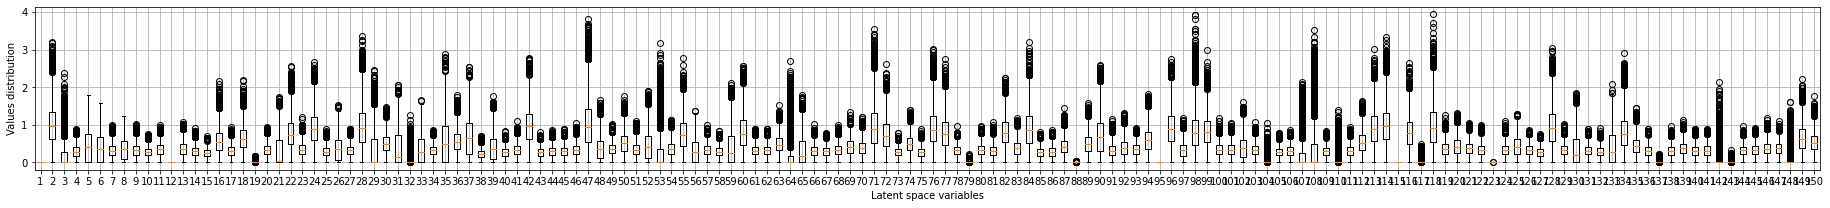

In [21]:
plt.figure(figsize=(32, 3))
plt.boxplot(x_test_encoded[:,:150])
plt.xlabel('Latent space variables')
plt.ylabel('Values distribution')
plt.grid()
plt.show()

In [0]:
  with open("/content/drive/My Drive/embeddings_jp/infersent_1024_encoding.pkl", 'wb') as f:
    pickle.dump(x_train_encoded,f) 

# Autoencoder
con espacio latente de 2048

In [22]:
latent_len=2048
# Q(z|x) -- Define encoder
in_layer = Input(shape=(4096,), name='INPUT')
h_q = Dense(latent_len, activation='relu', name='H_Q')(in_layer)

decode_in_layer = Input(shape=(latent_len,), name='IN_DECOD')
decode_out_layer = Dense(4096, activation='sigmoid', name='OUT')(decode_in_layer)

encoder = Model(in_layer, h_q, name='ENCODER')
decoder = Model(decode_in_layer, decode_out_layer, name='DECODER')

# Create full Variational Autoencoder
out_layer = decoder(encoder(in_layer))
ae = Model(in_layer, out_layer, name='VAE')

ae.summary()



Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
INPUT (InputLayer)           [(None, 4096)]            0         
_________________________________________________________________
ENCODER (Model)              (None, 2048)              8390656   
_________________________________________________________________
DECODER (Model)              (None, 4096)              8392704   
Total params: 16,783,360
Trainable params: 16,783,360
Non-trainable params: 0
_________________________________________________________________


In [23]:
# Compile and train
batch_size=100
ae.compile(optimizer='adam', loss='mse', experimental_run_tf_function=False)
history = ae.fit(emb_train, emb_train, epochs=50, batch_size=batch_size, validation_split=0.2)

Epoch 1/50
259/259 [==============================] - 3s 13ms/step - loss: 0.0077 - val_loss: 0.0045
Epoch 2/50
259/259 [==============================] - 3s 12ms/step - loss: 0.0044 - val_loss: 0.0045
Epoch 3/50
259/259 [==============================] - 3s 12ms/step - loss: 0.0044 - val_loss: 0.0045
Epoch 4/50
259/259 [==============================] - 3s 12ms/step - loss: 0.0044 - val_loss: 0.0045
Epoch 5/50
259/259 [==============================] - 3s 12ms/step - loss: 0.0044 - val_loss: 0.0045
Epoch 6/50
259/259 [==============================] - 3s 12ms/step - loss: 0.0044 - val_loss: 0.0045
Epoch 7/50
259/259 [==============================] - 3s 12ms/step - loss: 0.0044 - val_loss: 0.0045
Epoch 8/50
259/259 [==============================] - 3s 12ms/step - loss: 0.0044 - val_loss: 0.0045
Epoch 9/50
259/259 [==============================] - 3s 13ms/step - loss: 0.0044 - val_loss: 0.0045
Epoch 10/50
259/259 [==============================] - 3s 12ms/step - loss: 0.0044 - val_lo

In [0]:
# Plot distribution of latent space
x_test_encoded = encoder.predict(emb_test, batch_size=100)
x_train_encoded = encoder.predict(emb_train, batch_size=100)
encoded_embedding=encoder.predict(embedding, batch_size=100)

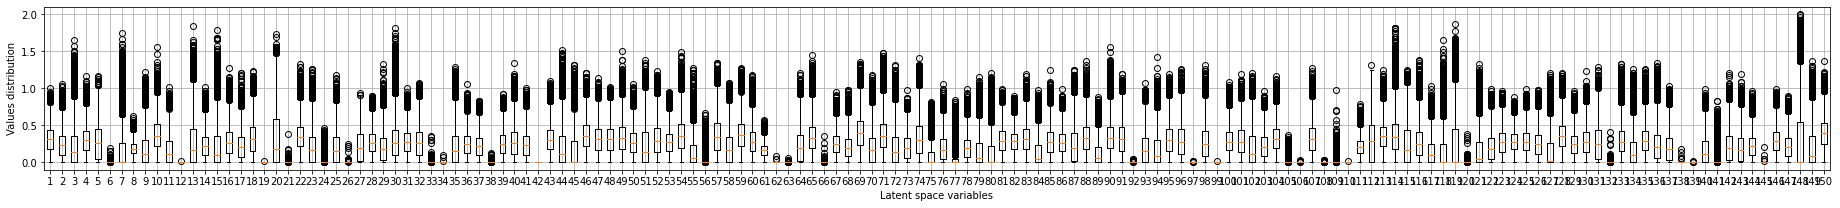

In [31]:
#asi se ven los primeros 150 entradas del espacio latente
plt.figure(figsize=(32, 3))
plt.boxplot(encoded_embedding[:,:150])
plt.xlabel('Latent space variables')
plt.ylabel('Values distribution')
plt.grid()
plt.show()

In [0]:
  with open("/content/drive/My Drive/embeddings_jp/infersent_2048_encoding.pkl", 'wb') as f:
    pickle.dump(encoded_embedding,f)